# Proyecto 2: Análisis de mercado inmobiliario. Modelos Avanzados

Creado por Vanesa Flores.

## Objetivo

Crear un modelo Machine Learning que, dadas ciertas características de la propiedad, prediga su precio de venta.


### Librerías útiles

In [1]:
#Importo algunas Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

#Preprocesamiento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

# Ingeniería de Features

Cargamos los datos usando la librería `Pandas` y observamos sus características:

In [2]:
df= pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')
df.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


In [3]:
df.shape

(146660, 19)

In [4]:
df.columns

Index(['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'l3',
       'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'currency', 'title', 'description', 'property_type',
       'operation_type'],
      dtype='object')

Consideraremos descartar algunas columnas que no aportan información relevante relacionada al objetivo del proyecto y renombramos otras para un mejor entendimiento: 

In [5]:
df=df.drop(columns=['lat', 'lon', 'start_date', 'end_date', 'created_on','title', 'description', 'currency','operation_type','l1'])
df.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH


In [6]:
df= df.rename(columns={'l2':'provincia','l3':'barrio'})
df.head()

,provincia,barrio,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH


Basándonos en lo estudiado en el primer proyecto, se considera tomar los tipos de propiedad que presentan mayor cantidad de anuncios en nuestro dataset: Departamento, Casa y PH, que representa un 97.6% del total de instancias. También nos quedamos con los anuncios en la provincia: Capital Federal la cual contiene el 63.1% de nuestras observaciones. 

In [7]:
df= df[(df.property_type.isin(['Departamento', 'Casa','PH']) & (df.provincia== 'Capital Federal'))]
df.head()

,provincia,barrio,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
5,Capital Federal,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH


In [8]:
df.shape

(91485, 9)

Ésto nos deja con un muestra que conserva el 62.37% de nuestro dataset original. Observemos inicialmente cómo se correlacionan estas variables:

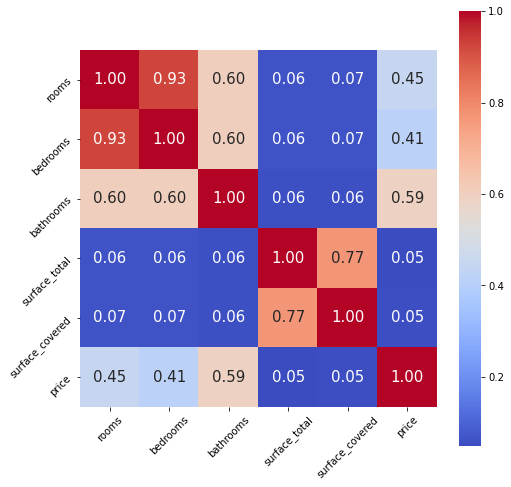

In [9]:
#Correlación inicial
corr_0=df.corr()

plt.figure(figsize=(8,8))
ax=sns.heatmap(corr_0, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

Se tiene que no existe correlaciones elevadas entre las variables independientes y la variable objetivo `Price`. Sin embargo, la mayor correlación la presentan las variables `rooms`, `bedrooms` y `bathrooms`.

# Imputación de datos faltantes

En lo que sigue vamos a observar de forma detallada la presencia de datos faltantes en nuestro dataset.

In [10]:
faltantes=df.isna().sum()
print('Valores faltantes por columnas:', faltantes)

Valores faltantes por columnas: provincia             0
barrio                0
rooms                 0
bedrooms              0
bathrooms          2171
surface_total      8917
surface_covered    9235
price                 0
property_type         0
dtype: int64


Calculemos el porcentaje de faltantes en los atributos de Bathrooms, Surface_total y Surface_covered.

In [11]:
cant_total=df.barrio.count()
porcentaje_Na=(faltantes/cant_total)*100
porcentaje_Na

provincia           0.000000
barrio              0.000000
rooms               0.000000
bedrooms            0.000000
bathrooms           2.373067
surface_total       9.746953
surface_covered    10.094551
price               0.000000
property_type       0.000000
dtype: float64

Tenemos un total de 91485 instancias. Donde las variables `bathrooms`, `surface_total` y `surface_covered` poseen un 2.37%, 9.74% y 10.09% de valores faltantes en nuestro dataset, respectivamente. Considerando que el porcentaje de datos faltantes es bajo se decide eliminar las instancias que los contengan.

Con ésto estaríamos evitando realizar una imputación de nulos que quizás luego pudiese sesgar de alguna manera nuestros datos. Sabiendo que los métodos de imputación se basan en medidas de tendencia central como la media o la mediana que presentan poca robutez.

Sin embargo, con intención de evidenciar lo antes mencionado se planteará una imputación de datos faltantes usando la clase `SimpleImputer` de `scikit-learn`. Para luego, al final del proyecto considerar realizar de nuevo la evaluación de los modelos sin eliminar los datos faltantes y poder establecer una comparación. 

In [12]:
df_sinNA= df.dropna()
df_sinNA.shape

(81210, 9)

In [13]:
df_sinNA.isnull().sum()

provincia          0
barrio             0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
property_type      0
dtype: int64

In [14]:
df_sinNA= df_sinNA.reset_index()

* Implementación de la clase `SimpleImputer`:

In [15]:
#Imputaremos con la media
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [16]:
df_imput= df.drop(columns=[ 'provincia', 'barrio','property_type'])
imp_mean.fit(df_imput)

SimpleImputer()

In [17]:
imp_mean.transform(df_imput)

array([[7.00e+00, 7.00e+00, 2.00e+00, 1.40e+02, 1.40e+02, 1.53e+05],
       [2.00e+00, 1.00e+00, 2.00e+00, 7.00e+01, 5.80e+01, 1.59e+05],
       [2.00e+00, 1.00e+00, 1.00e+00, 4.50e+01, 4.50e+01, 1.25e+05],
       ...,
       [4.00e+00, 2.00e+00, 2.00e+00, 3.17e+02, 1.43e+02, 5.30e+05],
       [3.00e+00, 2.00e+00, 2.00e+00, 1.45e+02, 1.45e+02, 4.20e+05],
       [4.00e+00, 3.00e+00, 5.00e+00, 2.20e+02, 2.10e+02, 1.47e+06]])

In [18]:
df_impt= pd.DataFrame(imp_mean.transform(df_imput), columns=['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price'])
df_impt.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
0,7.0,7.0,2.0,140.0,140.0,153000.0
1,2.0,1.0,2.0,70.0,58.0,159000.0
2,2.0,1.0,1.0,45.0,45.0,125000.0
3,2.0,1.0,1.0,85.0,50.0,295000.0
4,2.0,1.0,1.0,56.0,56.0,150000.0


In [19]:
df_impt.isnull().sum()

rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
dtype: int64

De esta forma tenemos dos datasets, ambos sin datos faltantes, uno con nulos eliminados (`df_sinNA`) y otro con nulos imputados (`df_impt`). En lo que sigue, y basándonos en lo antes expuesto continuaremos con el dataset con los faltantes eliminados. 

# Detección de outliers

Siguiendo con el preprocesamiento de nuestro dataset, veamos ahora cómo es la distribución de la variables realizando boxplots para cada una de ellas:

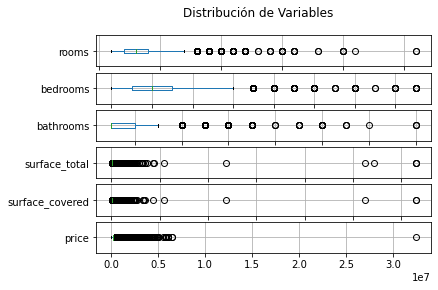

In [20]:
df_num= df_sinNA.drop(columns=['index','provincia', 'barrio', 'property_type'])
fig, axs = plt.subplots(6)
fig.suptitle('Distribución de Variables')
for i,el in enumerate(list(df_num.columns.values)[:]):
    a = df_sinNA.boxplot(el, ax=axs.flatten()[i],vert=False)

Se observa presencia de valores atípicos en todas las variables. Éstos parecen encontrarse con mayor peso en las últimas tres donde ni siquiera es posible distinguir una distribución de forma clara.

Para detectar la cantidad de outliers presente en cada variable, se utilizará la técnica del rango intercuartílico. 

### Cálculo de Rango Intercuartílico

In [21]:
columnas=['rooms','bedrooms','bathrooms','surface_total','surface_covered', 'price']
print('Valores= (q25,q75, IQR, mínimo, máximo)')
for i,columna in enumerate([df_sinNA.rooms,df_sinNA.bedrooms,df_sinNA.bathrooms,df_sinNA.surface_total,df_sinNA.surface_covered,df_sinNA.price]):
    q25,q75 = np.percentile(columna.values, [25,75])
    iqr = q75 - q25
    minimo = q25 - 1.5*iqr
    maximo = q75 + 1.5*iqr
    mascara_outliers = (columna < minimo) | (columna > maximo)
    cant_outliers=mascara_outliers.sum()
    print(f'Valores para {columnas[i]}:',q25,q75,iqr, minimo, maximo)
    print(f'Cantidad de outliers:',cant_outliers)

Valores= (q25,q75, IQR, mínimo, máximo)
Valores para rooms: 2.0 4.0 2.0 -1.0 7.0
Cantidad de outliers: 645
Valores para bedrooms: 1.0 3.0 2.0 -2.0 6.0
Cantidad de outliers: 263
Valores para bathrooms: 1.0 2.0 1.0 -0.5 3.5
Cantidad de outliers: 2919
Valores para surface_total: 49.0 111.0 62.0 -44.0 204.0
Cantidad de outliers: 6192
Valores para surface_covered: 44.0 96.0 52.0 -34.0 174.0
Cantidad de outliers: 6035
Valores para price: 125000.0 280000.0 155000.0 -107500.0 512500.0
Cantidad de outliers: 7059


Podemos observar que existe presencia de valores atípicos en todas nuestras variables. Sin embargo, sólo los eliminaremos para nuestra la variable objetivo, el precio.

In [22]:
df_sin_out=df_sinNA[(df_sinNA.price > 0 ) & (df_sinNA.price < 512500.0)]

df_sin_out=df_sin_out.reindex(columns=['index','provincia','barrio','rooms','bedrooms','bathrooms', 'surface_total', 'surface_covered', 'price','property_type'])
df_sin_out.drop(['index'], axis=1, inplace=True)
df_sin_out.head()

,provincia,barrio,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
4,Capital Federal,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH


Observemos ahora la distribución de la variable precio luego de eliminar valores atípicos

C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

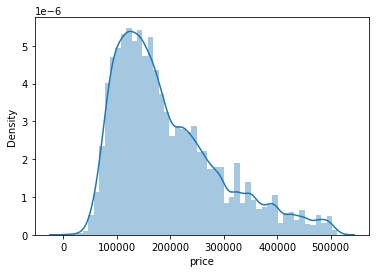

In [23]:
sns.distplot(df_sin_out.price)

C:\Users\vanes\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

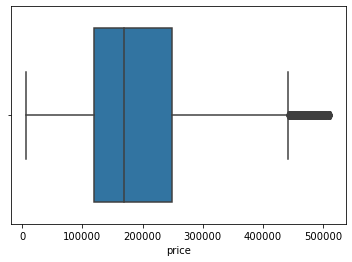

In [24]:
sns.boxplot(df_sin_out.price)

Nos encontramos con una distribución que presenta asimetría positiva que pudiese estar relacionada a propiedades que tengan una superficie grande o que se encuentren en algún barrio que por sus características sea más costoso en la Ciudad. Agrupemos por tipo de propiedad y barrio para observarlo:

In [25]:
df_sin_out.loc[df_sin_out.price > 400000].groupby(['property_type']).size()

property_type
Casa             302
Departamento    2770
PH               357
dtype: int64

In [26]:
df_sin_out.loc[df_sin_out.price > 400000].groupby(['barrio']).size()

barrio
Abasto                    3
Agronomía                 4
Almagro                  54
Balvanera                15
Barracas                 25
Barrio Norte            231
Belgrano                508
Boedo                     7
Caballito               230
Centro / Microcentro      4
Chacarita                14
Coghlan                  16
Colegiales               47
Congreso                  8
Constitución              3
Flores                   81
Floresta                 13
Las Cañitas              99
Liniers                   4
Mataderos                12
Monserrat                 5
Monte Castro              7
Nuñez                   127
Once                      3
Palermo                 749
Parque Centenario         4
Parque Chacabuco         11
Parque Chas               6
Parque Patricios          1
Paternal                  8
Pompeya                   2
Puerto Madero           188
Recoleta                521
Retiro                   75
Saavedra                 21
San Cristobal

Los barrios que poseen mayor cantidad de propiedades costosas son los más residenciales y que además, están categorizados como "caros" en la Capital Federal.

# Encoders

Buscaremos generar variables binarias para los atributos `barrio` y `property_type` con el objetivo de incluirlas en los modelos y encontrar mejor desempeño de los mismos. Para esto haremos la codificación de la variable utilizando la funcionalidad `OneHotEncoder` de `Scikit-Learn`.

In [27]:
ohe = OneHotEncoder(sparse=False).fit_transform(df_sin_out[['barrio','property_type']])
categoricas = pd.DataFrame(ohe)

In [28]:
categoricas = categoricas.set_index(df_sin_out.index)
df_encoding_mean = pd.concat([df_sin_out, categoricas], axis=1)
df_encoding_mean.head()

,provincia,barrio,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,0,...,50,51,52,53,54,55,56,57,58,59
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Capital Federal,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [29]:
df_encoding_mean.columns=['provincia','barrio','rooms','bedrooms','bathrooms', 'surface_total', 'surface_covered', 'price','property_type',
                                                   'Abasto', 'Agronomía', 'Almagro', 'Balvanera', 'Barracas', 'Barrio Norte', 'Belgrano', 'Boca', 'Boedo',
                                                   'Caballito', 'Catalinas', 'Centro / Microcentro', 'Chacarita', 'Coghlan', 'Colegiales', 'Congreso',
                                                   'Constitución', 'Flores', 'Floresta', 'Las Cañitas', 'Liniers', 'Mataderos', 'Monserrat', 'Monte Castro',
                                                   'Nuñez', 'Once', 'Palermo', 'Parque Avellaneda', 'Parque Centenario', 'Parque Chacabuco', 'Parque Chas',
                                                   'Parque Patricios', 'Paternal', 'Pompeya', 'Puerto Madero', 'Recoleta', 'Retiro', 'Saavedra', 'San Cristobal',
                                                   'San Nicolás', 'San Telmo', 'Tribunales', 'Velez Sarsfield', 'Versalles', 'Villa Crespo', 'Villa Devoto',
                                                   'Villa General Mitre', 'Villa Lugano', 'Villa Luro', 'Villa Ortuzar', 'Villa Pueyrredón', 'Villa Real',
                                                   'Villa Riachuelo', 'Villa Santa Rita', 'Villa Soldati', 'Villa Urquiza','Villa del Parque','Casa', 
                                                   'Departamento', 'PH']
df_encoding_mean.drop(columns='provincia', inplace=True)
df_encoding_mean.head()

,barrio,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,Abasto,Agronomía,...,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque,Casa,Departamento,PH
0,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Escalado de datos

Sabiendo que algunos algoritmos Machine Learning son sensibles a la escala en las que se miden nuestros atributos, procedemos a realizar un escalado de los mismos utilizando la clase `MinMaxScaler` de `scikit-learn` que nos permite obtener atributos escalados en un rango determinado. Esto con la intención de evitar falsos resultados de nuestros modelos más adelante.

En este punto, para facilitar volver después a nuestros datos no escalados se realizará el escalado por separado de las variables independientes y las variables dependientes.

In [30]:
scaler_independientes= MinMaxScaler(feature_range=(0,1))
scaler_dependientes=MinMaxScaler(feature_range=(0,1))

En lo que sigue, selecciono las variables con las que más adelante trabajaré con mis modelos. 

In [31]:
#Selecciono variables numéricas
variables_independientes=df_encoding_mean[['rooms','bedrooms','bathrooms', 'surface_total', 'surface_covered',
                                                   'Abasto', 'Agronomía', 'Almagro', 'Balvanera', 'Barracas', 'Barrio Norte', 'Belgrano', 'Boca', 'Boedo',
                                                   'Caballito', 'Catalinas', 'Centro / Microcentro', 'Chacarita', 'Coghlan', 'Colegiales', 'Congreso',
                                                   'Constitución', 'Flores', 'Floresta', 'Las Cañitas', 'Liniers', 'Mataderos', 'Monserrat', 'Monte Castro',
                                                   'Nuñez', 'Once', 'Palermo', 'Parque Avellaneda', 'Parque Centenario', 'Parque Chacabuco', 'Parque Chas',
                                                   'Parque Patricios', 'Paternal', 'Pompeya', 'Puerto Madero', 'Recoleta', 'Retiro', 'Saavedra', 'San Cristobal',
                                                   'San Nicolás', 'San Telmo', 'Tribunales', 'Velez Sarsfield', 'Versalles', 'Villa Crespo', 'Villa Devoto',
                                                   'Villa General Mitre', 'Villa Lugano', 'Villa Luro', 'Villa Ortuzar', 'Villa Pueyrredón', 'Villa Real',
                                                   'Villa Riachuelo', 'Villa Santa Rita', 'Villa Soldati', 'Villa Urquiza','Villa del Parque','Casa', 
                                                   'Departamento', 'PH']]
variables_dependientes=df_encoding_mean[['price']]

In [32]:
fit_independientes=scaler_independientes.fit(variables_independientes)
fit_dependientes=scaler_dependientes.fit(variables_dependientes)

In [33]:
escalados_independientes=scaler_independientes.transform(variables_independientes)
escalados_dependientes=scaler_dependientes.transform(variables_dependientes)

In [34]:
df_escalados_independientes=pd.DataFrame(escalados_independientes, columns=['rooms','bedrooms','bathrooms', 'surface_total', 'surface_covered',
                                                   'Abasto', 'Agronomía', 'Almagro', 'Balvanera', 'Barracas', 'Barrio Norte', 'Belgrano', 'Boca', 'Boedo',
                                                   'Caballito', 'Catalinas', 'Centro / Microcentro', 'Chacarita', 'Coghlan', 'Colegiales', 'Congreso',
                                                   'Constitución', 'Flores', 'Floresta', 'Las Cañitas', 'Liniers', 'Mataderos', 'Monserrat', 'Monte Castro',
                                                   'Nuñez', 'Once', 'Palermo', 'Parque Avellaneda', 'Parque Centenario', 'Parque Chacabuco', 'Parque Chas',
                                                   'Parque Patricios', 'Paternal', 'Pompeya', 'Puerto Madero', 'Recoleta', 'Retiro', 'Saavedra', 'San Cristobal',
                                                   'San Nicolás', 'San Telmo', 'Tribunales', 'Velez Sarsfield', 'Versalles', 'Villa Crespo', 'Villa Devoto',
                                                   'Villa General Mitre', 'Villa Lugano', 'Villa Luro', 'Villa Ortuzar', 'Villa Pueyrredón', 'Villa Real',
                                                   'Villa Riachuelo', 'Villa Santa Rita', 'Villa Soldati', 'Villa Urquiza','Villa del Parque','Casa', 
                                                   'Departamento', 'PH'])
df_escalados_dependientes=pd.DataFrame(escalados_dependientes, columns=["price"])

In [35]:
df_escalados_independientes.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,Abasto,Agronomía,Almagro,Balvanera,Barracas,...,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque,Casa,Departamento,PH
0,0.30,0.466667,0.076923,0.001031,0.001103,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.05,0.066667,0.076923,0.000476,0.000452,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.05,0.066667,0.000000,0.000278,0.000349,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.05,0.066667,0.000000,0.000595,0.000389,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.05,0.066667,0.000000,0.000365,0.000436,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
df_escalados = pd.concat([df_escalados_independientes,df_escalados_dependientes], axis=1)
df_escalados.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,Abasto,Agronomía,Almagro,Balvanera,Barracas,...,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque,Casa,Departamento,PH,price
0,0.30,0.466667,0.076923,0.001031,0.001103,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.290342
1,0.05,0.066667,0.076923,0.000476,0.000452,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.302193
2,0.05,0.066667,0.000000,0.000278,0.000349,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.235039
3,0.05,0.066667,0.000000,0.000595,0.000389,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.570809
4,0.05,0.066667,0.000000,0.000365,0.000436,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.284417


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

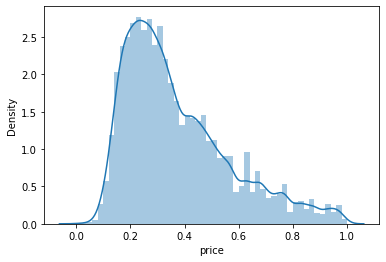

In [37]:
sns.distplot(df_escalados.price)

Se observa que la distribución de los datos es la misma, y que nuestra variable precio esta contemplada en un rango del 0 al 1. 

# Relación entre variables 

Observemos un poco las características de nuestros atributos:

In [38]:
df_escalados.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,Abasto,Agronomía,Almagro,Balvanera,Barracas,...,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque,Casa,Departamento,PH,price
count,74151.000000,74151.000000,74151.000000,74151.000000,74151.000000,74151.000000,74151.000000,74151.000000,74151.000000,74151.000000,...,74151.000000,74151.000000,74151.000000,74151.000000,74151.000000,74151.000000,74151.000000,74151.000000,74151.000000,74151.000000
mean,0.092639,0.125961,0.031604,0.000719,0.000656,0.005489,0.002023,0.091556,0.032110,0.008806,...,0.001726,0.000432,0.004059,0.000877,0.038624,0.016480,0.022737,0.851169,0.126094,0.372452
std,0.058169,0.064951,0.051681,0.008183,0.006454,0.073883,0.044931,0.288401,0.176294,0.093429,...,0.041512,0.020769,0.063583,0.029594,0.192698,0.127313,0.149066,0.355925,0.331958,0.195085
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.050000,0.066667,0.000000,0.000301,0.000333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.225163
50%,0.100000,0.133333,0.000000,0.000452,0.000468,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.321944
75%,0.150000,0.133333,0.076923,0.000698,0.000658,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.479954
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Veamos cómo están correlacionadas nuestras variables 

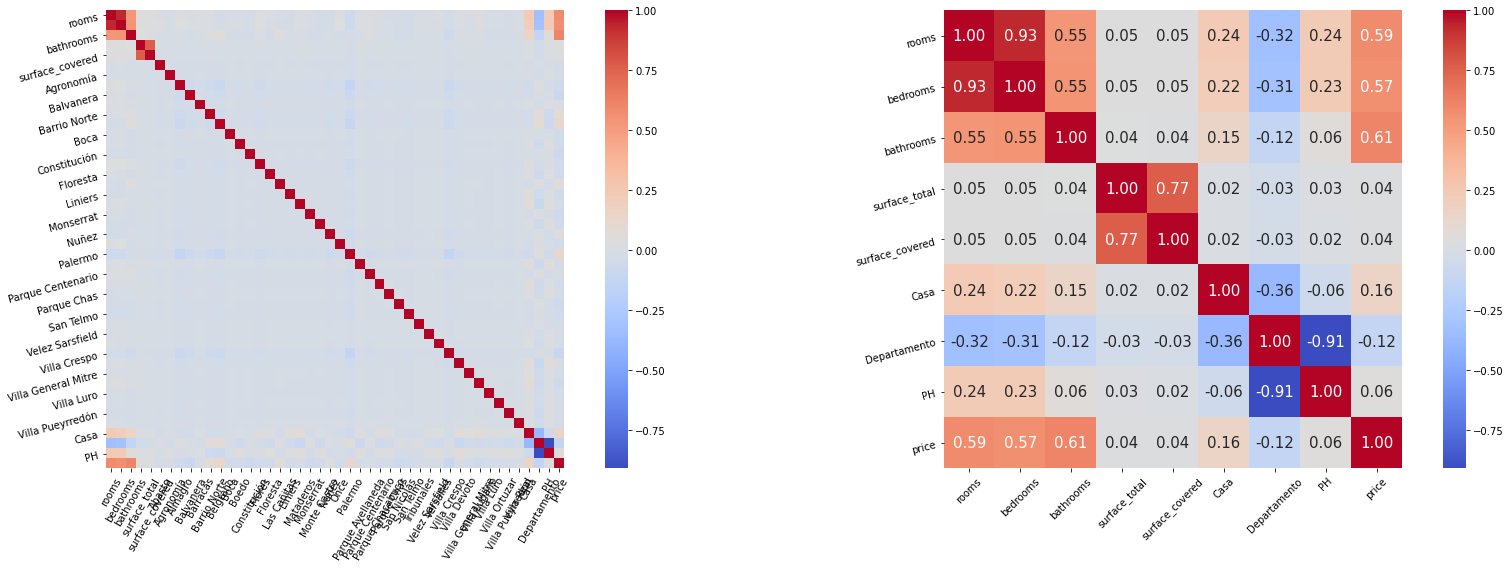

In [51]:
#Estudio de correlaciones
plt.figure(figsize = (8*3,8))

corr1=df_escalados[['rooms','bedrooms','bathrooms', 'surface_total', 'surface_covered',
                                                   'Abasto', 'Agronomía', 'Almagro', 'Balvanera', 'Barracas', 'Barrio Norte', 'Belgrano', 'Boca', 'Boedo',
                                                   'Constitución', 'Flores', 'Floresta', 'Las Cañitas', 'Liniers', 'Mataderos', 'Monserrat', 'Monte Castro',
                                                   'Nuñez', 'Once', 'Palermo', 'Parque Avellaneda', 'Parque Centenario', 'Parque Chacabuco', 'Parque Chas',
                                                   'San Nicolás', 'San Telmo', 'Tribunales', 'Velez Sarsfield', 'Versalles', 'Villa Crespo', 'Villa Devoto',
                                                   'Villa General Mitre', 'Villa Lugano', 'Villa Luro', 'Villa Ortuzar', 'Villa Pueyrredón', 'Villa Real','Casa', 
                                                   'Departamento', 'PH','price']].corr()
plt.subplot(1, 2, 1)
ax=sns.heatmap(corr1, cbar = True,  square = True, annot=False, fmt= '.2f',annot_kws={'size': 15},
           cmap= 'coolwarm')
plt.xticks(rotation = 60)
plt.yticks(rotation = 15)

plt.subplot(1, 2, 2)
corr2=df_escalados[['rooms', 'bedrooms', 'bathrooms','surface_total', 'surface_covered', 'Casa','Departamento','PH','price']].corr()
ax=sns.heatmap(corr2, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 15)

plt.tight_layout()
plt.show()

El mapa de calor del lado izquierdo muestra que las variables binarias generadas para los barrios no muestran correlación significativa con la variable target. 

Sin embargo, para el gráfico del lado derecho se filtran las variables a fin observar con mayor claridad las correlaciones. Se obtiene que comparándo con el Proyecto 1, se observa gran diferencia en las correlaciones respecto a la variable objetivo. Ésta variación pudiese estar relacionada a la eliminación de valores atípicos sobre las variables de superficie. 

# Reducción de la Dimensionalidad (PCA)

En lo que sigue, aplicaremos el método de Análisis de Componentes Principales para indagar si a partir de la reducción de atributos y generación de nuevas variables que obtengan la mayor variabilidad, se encontraran mejores resultados en nuestros modelos.

Lo primero que haremos será separar nuestras variables dependientes de las independientes.

In [52]:
X=df_escalados[['rooms','bedrooms','bathrooms', 'surface_total', 'surface_covered',
                                                   'Abasto', 'Agronomía', 'Almagro', 'Balvanera', 'Barracas', 'Barrio Norte', 'Belgrano', 'Boca', 'Boedo',
                                                   'Caballito', 'Catalinas', 'Centro / Microcentro', 'Chacarita', 'Coghlan', 'Colegiales', 'Congreso',
                                                   'Constitución', 'Flores', 'Floresta', 'Las Cañitas', 'Liniers', 'Mataderos', 'Monserrat', 'Monte Castro',
                                                   'Nuñez', 'Once', 'Palermo', 'Parque Avellaneda', 'Parque Centenario', 'Parque Chacabuco', 'Parque Chas',
                                                   'Parque Patricios', 'Paternal', 'Pompeya', 'Puerto Madero', 'Recoleta', 'Retiro', 'Saavedra', 'San Cristobal',
                                                   'San Nicolás', 'San Telmo', 'Tribunales', 'Velez Sarsfield', 'Versalles', 'Villa Crespo', 'Villa Devoto',
                                                   'Villa General Mitre', 'Villa Lugano', 'Villa Luro', 'Villa Ortuzar', 'Villa Pueyrredón', 'Villa Real',
                                                   'Villa Riachuelo', 'Villa Santa Rita', 'Villa Soldati', 'Villa Urquiza','Villa del Parque','Casa', 
                                                   'Departamento', 'PH']]
y=df_escalados[['price']]

Utilizamos la función `PCA` de `scikit-learn` para calcular las componentes principales. Para empezar, consideraremos graficar la variabilidad explicada respecto al número de componentes calculadas y estableciendo un umbral de corte que nos indique cuántas componentes nos explican el 95% de la varianza. 

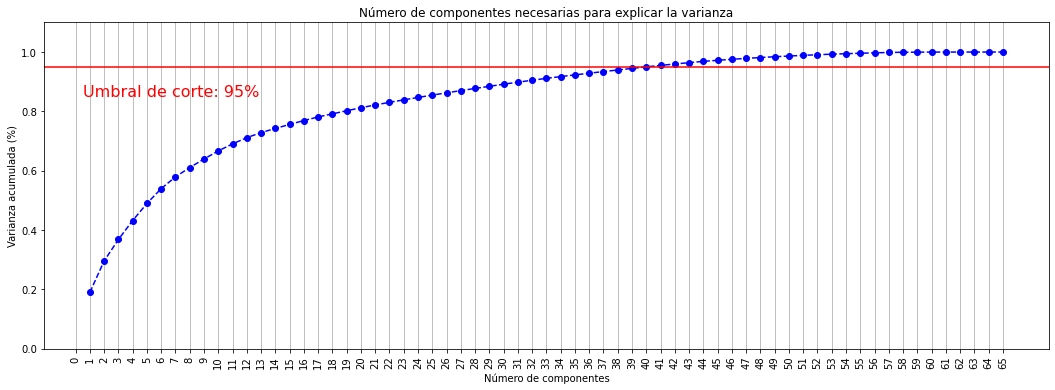

In [55]:
pca = PCA().fit(X)

plt.rcParams["figure.figsize"] = (18,6)

fig, ax = plt.subplots()
xi = np.arange(1, 66, step=1)
yi = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

plt.xlabel('Número de componentes')
plt.xticks(np.arange(0, 66, step=1), rotation=90) 
plt.ylabel('Varianza acumulada (%)')
plt.title('Número de componentes necesarias para explicar la varianza')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, 'Umbral de corte: 95%', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

Nos quedamos entonces con las primeras 40 componentes principales calculadas.

In [58]:
pca = PCA(n_components=40)
X_nuevo = pca.fit_transform(X) 

In [61]:
pca.components_

array([[ 3.66555780e-02,  3.98457899e-02,  1.07651534e-02, ...,
         6.21550053e-02, -7.29906353e-01,  6.67751348e-01],
       [-6.74190141e-03, -8.58345071e-03, -2.38459732e-03, ...,
        -1.37375224e-02, -3.58028888e-02,  4.95404112e-02],
       [ 7.94937216e-03,  9.62392392e-03,  3.41058771e-04, ...,
        -1.64961257e-02, -1.46556208e-03,  1.79616878e-02],
       ...,
       [ 1.24189340e-01,  1.40965050e-01,  9.39326119e-02, ...,
        -2.14913267e-02,  2.02207925e-02,  1.27053420e-03],
       [ 7.38435669e-02,  8.21847922e-02,  1.84734066e-02, ...,
        -1.41116997e-02,  1.12281496e-02,  2.88355014e-03],
       [ 1.76362434e-01,  2.03935555e-01,  1.00741418e-01, ...,
        -5.04491343e-02,  4.27059089e-02,  7.74322537e-03]])

In [62]:
np.cumsum(pca.explained_variance_ratio_)

array([0.1895578 , 0.29537148, 0.36779472, 0.43170371, 0.48937429,
       0.53933462, 0.57906708, 0.61036229, 0.63916755, 0.66650451,
       0.69022762, 0.71117399, 0.72830623, 0.74230912, 0.75586764,
       0.7689362 , 0.78103103, 0.79153426, 0.80192534, 0.81210152,
       0.82158426, 0.83033714, 0.83863766, 0.84680372, 0.85475124,
       0.86244179, 0.86990926, 0.87716806, 0.88433807, 0.89147872,
       0.89827659, 0.9049287 , 0.91124803, 0.91717521, 0.92293642,
       0.92861669, 0.93412289, 0.93945952, 0.94475128, 0.94992086])

# Comparemos con el Proyecto 1

Luego del preprocesamiento de datos realizado, consideraremos entrenar tres modelos Machine Learning. Un árbol de decisión, KNN y regresión lineal con los mismos parámetros utilizados en el Proyecto 1 con el fin de comparar resultados. 

### Modelo 1: Árbol de Decisión con PCA

Realizamos ahora la división de nuestros datos, considerando un conjunto de datos de entrenamiento y otro de testeo. Es importante resaltar que en este punto nuestros atributos son las dos componentes pricipales calculadas (`X_nuevo`).

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_nuevo, y, test_size=0.30, random_state=42)

In [64]:
tree_regressor = DecisionTreeRegressor(max_depth=8, random_state=42)
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, random_state=42)

Definiremos una función que nos permitirá evaluar cada modelo de manera más fácil y además, nos mostrará los errores obtenidos mediante el cálculo del RMSE con las valores en la escala real y el valor de r2_score que nos indica el desempeño del modelo.

In [72]:
def evaluar_modelo(model, scaler, X_train, X_test, y_train, y_test):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    ### VOLVEMOS A LAS VARIABLES NO ESCALADAS
    y_train_pred_desesc = scaler.inverse_transform(y_train_pred.reshape(-1, 1))
    y_test_pred_desesc = scaler.inverse_transform(y_test_pred.reshape(-1, 1))
    
    y_train_desesc = scaler.inverse_transform(y_train)
    y_test_desesc = scaler.inverse_transform(y_test)
    
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train_desesc, y_train_pred_desesc))
    rmse_test = np.sqrt(mean_squared_error(y_test_desesc, y_test_pred_desesc))

    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    r2=r2_score(y_true=y_test_desesc, y_pred=y_test_pred_desesc)
    print(f'El valor del r2 score : {r2}')
    
    plt.figure(figsize = (15,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train_desesc - y_train_pred_desesc, bins = 20, label = 'train')
    sns.distplot(y_test_desesc - y_test_pred_desesc, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()


    ax = plt.subplot(1,2,2)
    ax.scatter(y_test_desesc,y_test_pred_desesc, s =2)
   
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
      ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
   
    plt.tight_layout()
    plt.show()

Raíz del error cuadrático medio en Train: 55369.9349363334
Raíz del error cuadrático medio en Test: 55594.84470076954
El valor del r2 score : 0.6789403937979686


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


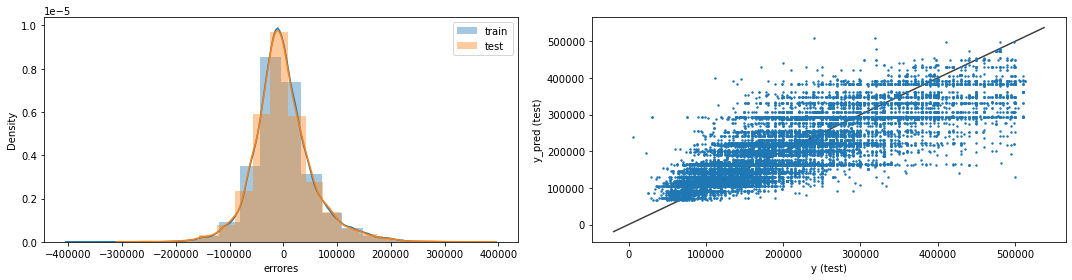

In [73]:
evaluar_modelo(tree_regressor, scaler_dependientes,X_train, X_test, y_train, y_test)

### Modelo 2: KNN con PCA

Raíz del error cuadrático medio en Train: 39261.32353477687
Raíz del error cuadrático medio en Test: 42334.09921067514
El valor del r2 score : 0.8138353267782201


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


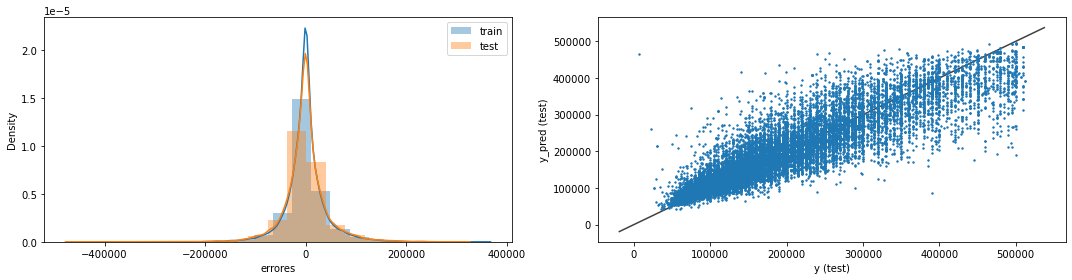

In [74]:
knn_regressor = KNeighborsRegressor(n_neighbors=10)
knn_regressor.fit(X_train, y_train)
evaluar_modelo(knn_regressor, scaler_dependientes,X_train, X_test, y_train, y_test)

### Modelo 3: Regresión Lineal con PCA

Raíz del error cuadrático medio en Train: 65750.65930627738
Raíz del error cuadrático medio en Test: 64776.66608583994
El valor del r2 score : 0.5641331799955336


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


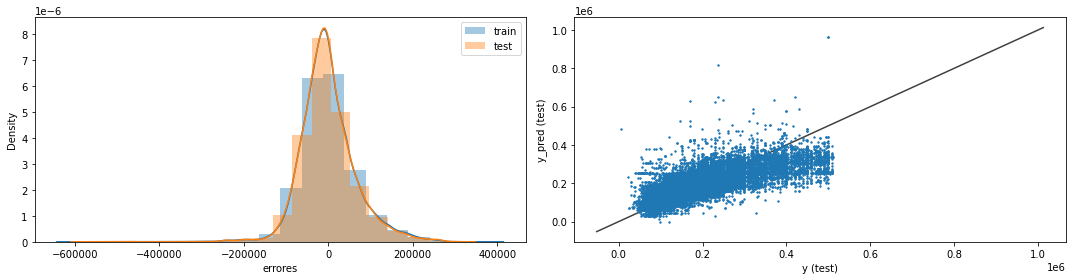

In [75]:
linear_model = LinearRegression() #Benchmark
linear_model.fit(X_train, y_train)
evaluar_modelo(linear_model, scaler_dependientes,X_train, X_test, y_train, y_test)

In [76]:
metricas= [[57286.50, 57958.02,-0.02, 65750.65, 64776.66, 0.56],
         [46297.29, 47935.92, 0.48, 55369.93,55594.84,0.68],
         [ 41839.18, 45999.04,0.57,39261.32,42334.09,0.81]]

columnas = ['RMSE_Train_P1', 'RMSE_Test_P1', 'R2_score_P1', 'RMSE_Train P2_PCA', 'RMSE_Test_P2_PCA', 'R2_score_P2_PCA'] # definimos los nombres de las columnas
filas = ['Regresión lineal', 'Árbol de Decisión', 'KNN'] # definimos los nombres de las filas

comparacion = pd.DataFrame(metricas, columns=columnas, index=filas)
comparacion.head()

,RMSE_Train_P1,RMSE_Test_P1,R2_score_P1,RMSE_Train P2_PCA,RMSE_Test_P2_PCA,R2_score_P2_PCA
Regresión lineal,57286.50,57958.02,-0.02,65750.65,64776.66,0.56
Árbol de Decisión,46297.29,47935.92,0.48,55369.93,55594.84,0.68
KNN,41839.18,45999.04,0.57,39261.32,42334.09,0.81


Se puede observar que el performance de los tres modelos indicados mejoran su desempeño respecto a los resultados obtenidos en el Proyecto 1, considerando los mismos hiperparámetros. Podemos resaltar que el modelo de vecinos más cercanos arroja el r2_score más alto y además, presenta similitud en la distribuciones de los errores de train y test, por lo que podemos inferir que no existe un sobreajuste significativo del modelo. 

Veamos ahora, cómo es el desempeño de nuestro modelos sin usar las componentes principales calculadas (PCA) y en cambio, usando sólo las variables predictoras que presentan mayor correlación con la variable objetivo.

In [78]:
X=df_escalados[['rooms','bedrooms','bathrooms']]
y=df_escalados[['price']]

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Modelo 4: Árbol de Decisión (Variables mayor corr)

Raíz del error cuadrático medio en Train: 68869.13599912835
Raíz del error cuadrático medio en Test: 68466.13527263881
El valor del r2 score : 0.5130680703911832


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


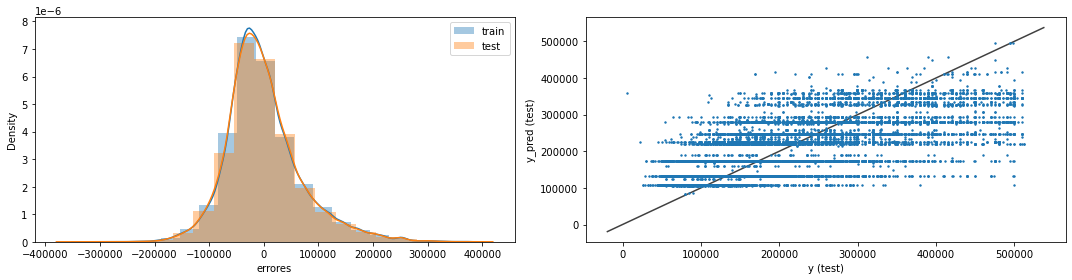

In [80]:
tree_regressor1 = DecisionTreeRegressor(max_depth=8, random_state=42)
tree_regressor1.fit(X_train, y_train)
evaluar_modelo(tree_regressor1, scaler_dependientes,X_train, X_test, y_train, y_test)

### Modelo 5: KNN (Variables mayor corr)

Raíz del error cuadrático medio en Train: 71935.27525306634
Raíz del error cuadrático medio en Test: 71387.44452848974
El valor del r2 score : 0.470628815733413


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


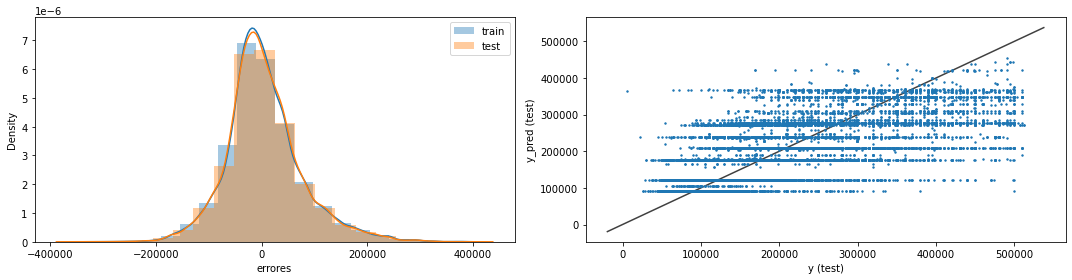

In [81]:
knn_regressor1 = KNeighborsRegressor(n_neighbors=10)
knn_regressor1.fit(X_train, y_train)
evaluar_modelo(knn_regressor1, scaler_dependientes,X_train, X_test, y_train, y_test)

### Modelo 6: Regresión Lineal (Variables mayor corr)

Raíz del error cuadrático medio en Train: 72248.10140366318
Raíz del error cuadrático medio en Test: 71127.17418543597
El valor del r2 score : 0.47448183096272833


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


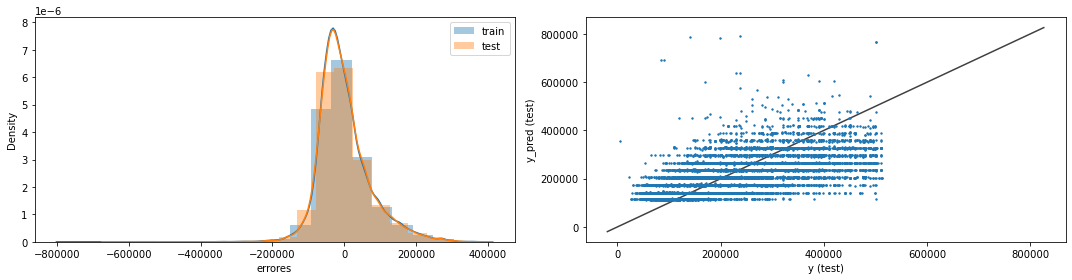

In [82]:
linear_model1 = LinearRegression() #Benchmark
linear_model1.fit(X_train, y_train)
evaluar_modelo(linear_model1, scaler_dependientes,X_train, X_test, y_train, y_test)

In [84]:
metricas= [[57286.50, 57958.02,-0.02, 65750.65, 64776.66, 0.56,72248.10, 71127.17,0.47],
         [46297.29, 47935.92, 0.48, 55369.93,55594.84,0.68, 68869.13, 68466.13, 0.51],
         [ 41839.18, 45999.04,0.57,39261.32,42334.09,0.81, 71935.27, 71387.44,  0.47]]

columnas = ['RMSE_Train_P1', 'RMSE_Test_P1', 'R2_score_P1', 'RMSE_Train P2_PCA', 'RMSE_Test_P2_PCA', 'R2_score_P2_PCA', 'RMSE_Train_var_corr', 'RMSE_Test_var_corr', 
            'R2_score_var_corr'] # definimos los nombres de las columnas
filas = ['Regresión lineal', 'Árbol de Decisión', 'KNN'] # definimos los nombres de las filas

comparacion = pd.DataFrame(metricas, columns=columnas, index=filas)
comparacion.head()

,RMSE_Train_P1,RMSE_Test_P1,R2_score_P1,RMSE_Train P2_PCA,RMSE_Test_P2_PCA,R2_score_P2_PCA,RMSE_Train_var_corr,RMSE_Test_var_corr,R2_score_var_corr
Regresión lineal,57286.50,57958.02,-0.02,65750.65,64776.66,0.56,72248.10,71127.17,0.47
Árbol de Decisión,46297.29,47935.92,0.48,55369.93,55594.84,0.68,68869.13,68466.13,0.51
KNN,41839.18,45999.04,0.57,39261.32,42334.09,0.81,71935.27,71387.44,0.47


De esta primera parte en donde hemos considerado evaluar los modelos con hiperparámetros definidos e iguales para cada iteración de los modelos, se obtiene:

- Realizar la reducción de dimensionalidad mediante el análisis de componentes principales nos ofrece mejoras significativas a nuestros modelos.

- El modelo que mejor performance arroja hasta ahora es el KNN.

- El modelo de regresión lineal mejora en relación a lo obtenido el el proyecto anterior, sin embargo, es el modelo que peor performance arroja.

- Se resalta que la distribución de densidad para los errores de los conjuntos de train y test no difieren significativamente en cada modelo. Además, los histogramas son bastantes simétricos y parecidos para ambos conjuntos.

# PARTE B.  Optimización de Hiperparámetros

En lo que sigue, se intentará optimizar los modelos anteriores haciendo uso de la funcionalidad `RandomizedSearchCV` de `scikit-learn`, la cual nos permite hacer variaciones de los hiperparámetros del modelo de forma aleatoria y además incluye la estrategia de Validación Cruzada para obtener independencia de la partición de nuestros datos.

Empecemos haciendo el entrenamiento de los modelos considerando la variables que presentan más correlación con nuestra variable objetivo. En esta parte sólo consideraremos los modelos árbol de decisión y knn ya que más adelante se propone realizar regresión con regularización y atributos polinómicos.

In [85]:
X=df_escalados[['rooms','bedrooms','bathrooms']]
y=df_escalados[['price']]

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Modelo 7: Árbol de Decisión CV (Variables mayor corr) 

In [87]:
tree_regressor2 = DecisionTreeRegressor(random_state=42)

Construyamos ahora la grilla de hiperparámetros los cuales serán generados de forma aleatoria para nuestro random search:

In [88]:
# Grilla para Random Search
param_dist = {'max_depth':np.arange(1,30),                #Profundidad del árbol
              'min_samples_split': [2,3,4],        #El número mínimo de muestras necesarias para dividir un nodo interno.
              }

Busquemos optimizar parámetros

In [89]:
random_search = RandomizedSearchCV(tree_regressor2, param_dist,n_iter=20, random_state=42, cv=5)
random_search.fit(X_train, y_train)
print("Mejores parametros: "+str(random_search.best_params_))
print("Mejor Score: "+str(random_search.best_score_)+'\n')

Mejores parametros: {'min_samples_split': 4, 'max_depth': 23}
Mejor Score: 0.5129030699467425



Reentrenamos con los mejores parámetros:

Raíz del error cuadrático medio en Train: 68734.79102354244
Raíz del error cuadrático medio en Test: 68479.1800666164
El valor del r2 score : 0.5128825032698279


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


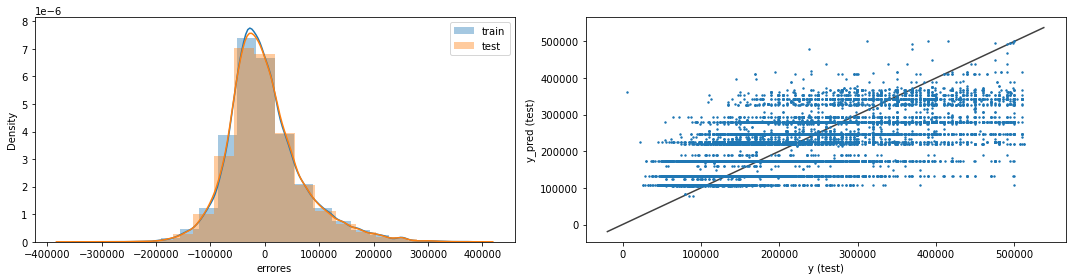

In [90]:
tree_regressor3 = DecisionTreeRegressor(max_depth=23, min_samples_split=4, random_state=42)
tree_regressor3.fit(X_train, y_train)
evaluar_modelo(tree_regressor3, scaler_dependientes,X_train, X_test, y_train, y_test)

### Modelo 8: KNN CV (Variables mayor corr)

In [91]:
knn_regressor2 = KNeighborsRegressor()

In [92]:
#Random Search
param_dist = {'n_neighbors':np.arange(10,30),     #Número de vecinos
              'weights': ['uniform', 'distance']}        #Función de peso (cómo se ponderan los scores)
random_search = RandomizedSearchCV(knn_regressor2, param_dist,n_iter=10, random_state=42, cv=5)
random_search.fit(X_train, y_train)
print("Mejores parametros: "+str(random_search.best_params_))
print("Mejor Score: "+str(random_search.best_score_)+'\n')

Mejores parametros: {'weights': 'distance', 'n_neighbors': 29}
Mejor Score: 0.49739276051898623



Raíz del error cuadrático medio en Train: 69899.82342688109
Raíz del error cuadrático medio en Test: 69611.44295094303
El valor del r2 score : 0.4966409303542192


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


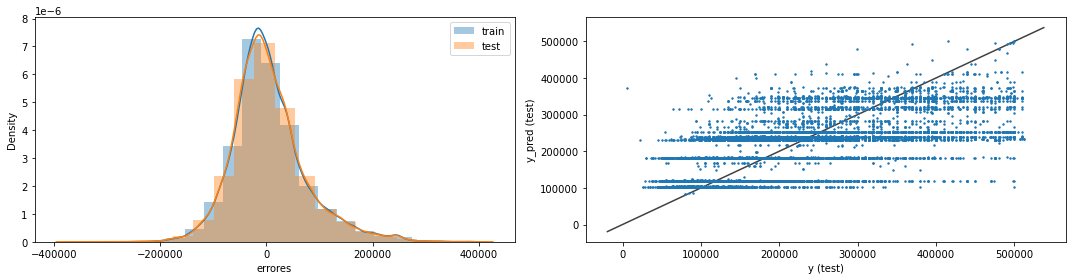

In [93]:
knn_regressor3 = KNeighborsRegressor(n_neighbors=29, weights='distance')
knn_regressor3.fit(X_train, y_train)
evaluar_modelo(knn_regressor3, scaler_dependientes,X_train, X_test, y_train, y_test)

Ahora, veamos el performance de los modelos considerando utilizar la variables generadas con Componentes Principales:

In [94]:
X=X_nuevo
y=df_escalados[['price']]
#Realizamos la partición de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Modelo 9: Árbol de Decisión CV y PCA 

In [95]:
tree_regressor4 = DecisionTreeRegressor(random_state=42)

In [96]:
#Random Search
param_dist = {'max_depth':np.arange(1,80),                #Profundidad del árbol
              'min_samples_split': [2,3,4],        #El número mínimo de muestras necesarias para dividir un nodo interno.
              }
random_search = RandomizedSearchCV(tree_regressor4, param_dist,n_iter=20, random_state=42, cv=5)
random_search.fit(X_train, y_train)
print("Mejores parametros: "+str(random_search.best_params_))
print("Mejor Score: "+str(random_search.best_score_)+'\n')

Mejores parametros: {'min_samples_split': 3, 'max_depth': 39}
Mejor Score: 0.7357350141369743



Raíz del error cuadrático medio en Train: 41058.512561129406
Raíz del error cuadrático medio en Test: 49137.44676352513
El valor del r2 score : 0.7491917612359242


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


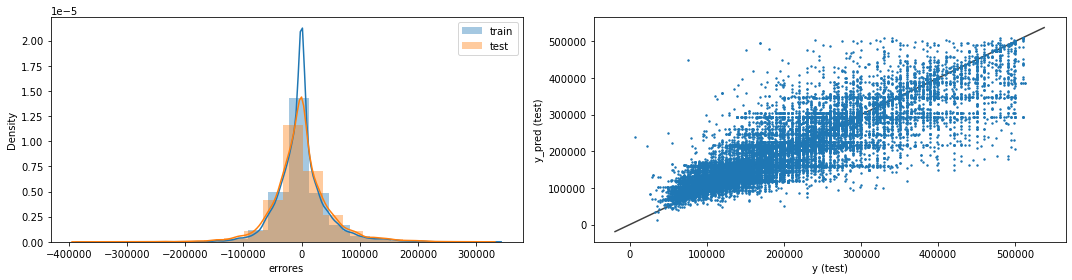

In [98]:
tree_regressor5 = DecisionTreeRegressor(max_depth=39, min_samples_split=3, random_state=42)
tree_regressor5.fit(X_train, y_train)
evaluar_modelo(tree_regressor5, scaler_dependientes,X_train, X_test, y_train, y_test)

### Modelo 10: KNN CV y PCA

In [99]:
knn_regressor4 = KNeighborsRegressor()

In [100]:
#Random Search
param_dist = {'n_neighbors':np.arange(10,100),     #Número de vecinos
              'weights': ['uniform', 'distance']}        #Función de peso (cómo se ponderan los scores)
random_search = RandomizedSearchCV(knn_regressor4, param_dist,n_iter=10, random_state=42, cv=5)
random_search.fit(X_train, y_train)
print("Mejores parametros: "+str(random_search.best_params_))
print("Mejor Score: "+str(random_search.best_score_)+'\n')

Mejores parametros: {'weights': 'distance', 'n_neighbors': 19}
Mejor Score: 0.8241220924951737



Raíz del error cuadrático medio en Train: 18377.275143022012
Raíz del error cuadrático medio en Test: 39262.54421266967
El valor del r2 score : 0.8398697053526203


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


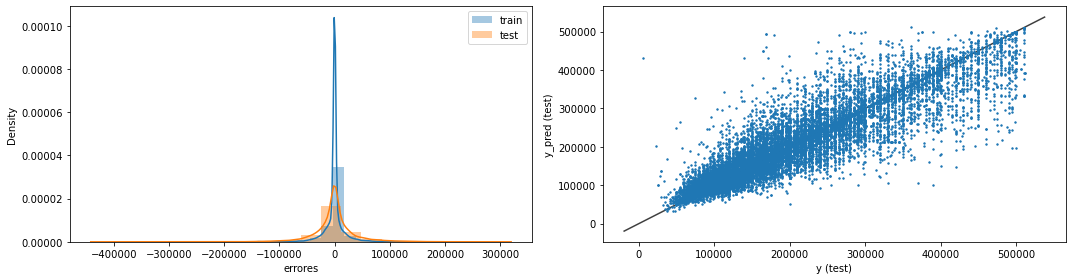

In [101]:
knn_regressor5 = KNeighborsRegressor(n_neighbors=19, weights='distance')
knn_regressor5.fit(X_train, y_train)
evaluar_modelo(knn_regressor5, scaler_dependientes,X_train, X_test, y_train, y_test)

In [104]:
metricas1= [[68734.79, 68479.18, 0.51, 41058.51, 49137.44, 0.75],
         [69899.82, 69611.44, 0.50,18377.27,39262.54,0.84]]

columnas1 = ['RMSE_Train_var_corr', 'RMSE_Test_var_corr', 'R2_score_var_corr','RMSE_Train_PCA', 'RMSE_Test_PCA', 'R2_score_PCA'] # definimos los nombres de las columnas
filas1 = ['Árbol de Decisión', 'KNN'] # definimos los nombres de las filas

comparacion1 = pd.DataFrame(metricas1, columns=columnas1, index=filas1)
comparacion1.head()

,RMSE_Train_var_corr,RMSE_Test_var_corr,R2_score_var_corr,RMSE_Train_PCA,RMSE_Test_PCA,R2_score_PCA
Árbol de Decisión,68734.79,68479.18,0.51,41058.51,49137.44,0.75
KNN,69899.82,69611.44,0.50,18377.27,39262.54,0.84


En la tabla comparativa se observa:
    
- Existe una pequeña mejoría en el desempeño de ambos modelos considerando las variables con mayor correlación después de la optimización de los hiperparámetros.

- Se encuentran distribuciones de densidad de errores que difieren bastante entre el conjunto de train y test, indicando así la presencia de un sobreajuste en nuestros modelos.  


# Modelos Avanzados

## Random Forest

Veamos ahora el desempeño de un modelo Random Forest entrenado tanto con la variables de mayor correlación con le precio como con las componentes principales.

En principio, entrenaremos el modelo con hiperparámetros puestos de forma manual para observar su desempeño. Luego, realizaremos la validación de hiperparámetros soportándonos en el error Out-of-Bag. Calcularemos los errores de entrenamiento y los oob_scores de forma iterativa variando la cantidad de estimadores en el modelo. De esta manera, podemos obtener cuántos árboles debe modelar el random forest para obtener el mejor performance.

No se realizará el método de optimización de parámetros por Validación Cruzada ya que presenta un costo computacional elevado.

### Modelo 11: Random Forest con PCA

In [102]:
X=X_nuevo
y=df_escalados[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

<ipython-input-103-7ec79496c106>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_train)


Raíz del error cuadrático medio en Train: 40445.0399378769
Raíz del error cuadrático medio en Test: 46287.77076286313
El valor del r2 score : 0.777438952419518


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


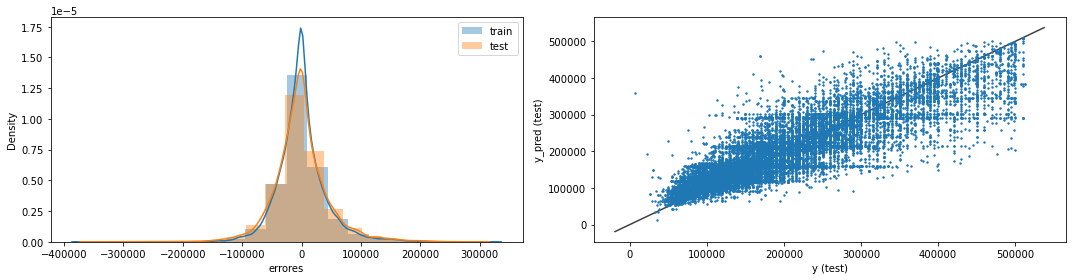

In [103]:
random_forest = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,               #Con -1 se utilizan todos los cores disponibles
            random_state = 42
         )
random_forest.fit(X_train, y_train)
evaluar_modelo(random_forest, scaler_dependientes,X_train, X_test, y_train, y_test)

<ipython-input-140-f1ca12f52d45>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest1.fit(X_train, y_train)
C:\Users\vanes\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
<ipython-input-140-f1ca12f52d45>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest1.fit(X_train, y_train)
C:\Users\vanes\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
<ipython-input-140-f1ca12f52d4

Valor óptimo de n_estimators: 46


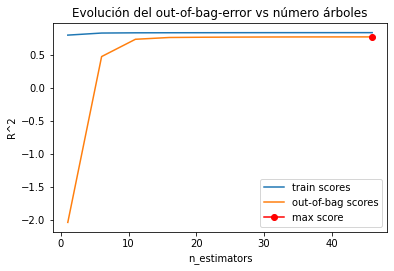

In [140]:
# Validación con Out-of-Bag error
train_scores = []
oob_scores   = []

# Número de estimadores a considerar
estimator_range = range(1, 50, 5)

# Iteramos para distintos valores de n_estimators
for n_estimators in estimator_range:
    random_forest1 = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 42
             )
    random_forest1.fit(X_train, y_train)
    train_scores.append(random_forest1.score(X_train, y_train))
    oob_scores.append(random_forest1.oob_score_)
    
# Graficamos el comportamiento de los errores train y obb_score respecto al número de estimadores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
#Imprimimos el valor óptimo 
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

Se observa que aproximadamente a partir de los 10 estimadores el error obb_score del modelo se estabiliza y se vuelve constante, llegando así a su valor más elevado. Por lo que ahora entrenaremos de nuevo modelo con el valor óptimo obtenido.

<ipython-input-141-867455fccfd1>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest2.fit(X_train, y_train)


Raíz del error cuadrático medio en Train: 40082.58215483444
Raíz del error cuadrático medio en Test: 46003.669272772204
El valor del r2 score : 0.7801626040600631


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


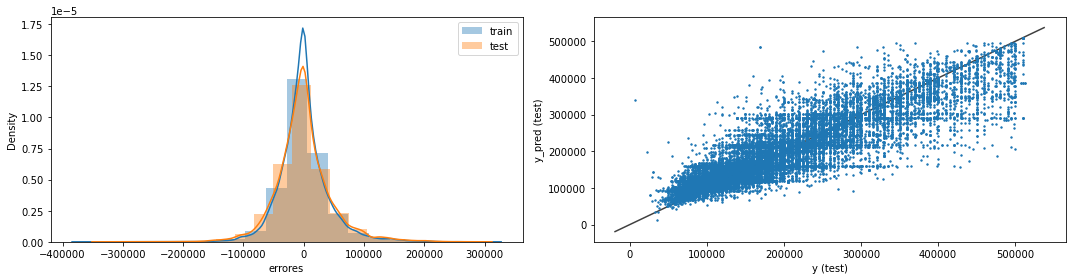

In [141]:
random_forest2 = RandomForestRegressor(
            n_estimators = 46,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,               #Con -1 se utilizan todos los cores disponibles
            random_state = 42
         )
random_forest2.fit(X_train, y_train)
evaluar_modelo(random_forest2, scaler_dependientes,X_train, X_test, y_train, y_test)

Observemos la importancia de los features:

C:\Users\vanes\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Importancias')

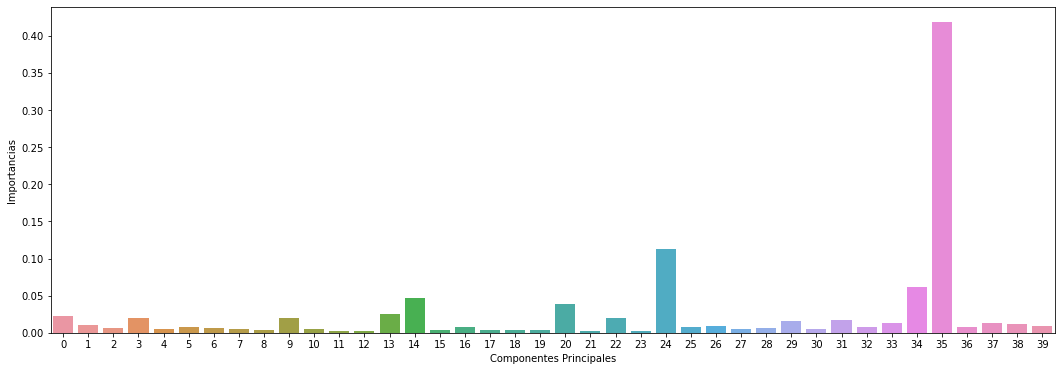

In [142]:
df_X_nuevo=pd.DataFrame(X_nuevo)
sns.barplot(df_X_nuevo.columns, random_forest2.feature_importances_)
plt.xlabel("Componentes Principales")
plt.ylabel("Importancias")

Se puede observar que sólo 4 componentes principales (14,24,34,35) son las que aportan al modelo una importancia mayor al 5%. Se esperaba que las primeras componentes que respresentaban mayor variabilidad de los datos fuesen las mejores variables predictoras para el modelo. Sin embargo, por ser estas componentes generadas al condensar la información de las variables originales, es difícil interpretar qué representan además de ser las más relevantes del modelo. 

### Modelo 11: Random Forest con variables más corr

In [143]:
X=df_escalados[['rooms','bedrooms','bathrooms']]
y=df_escalados[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

<ipython-input-144-bfdb95856b92>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest3.fit(X_train, y_train)
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Raíz del error cuadrático medio en Train: 68750.39038487762
Raíz del error cuadrático medio en Test: 68439.88048907137
El valor del r2 score : 0.5134414474240703


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


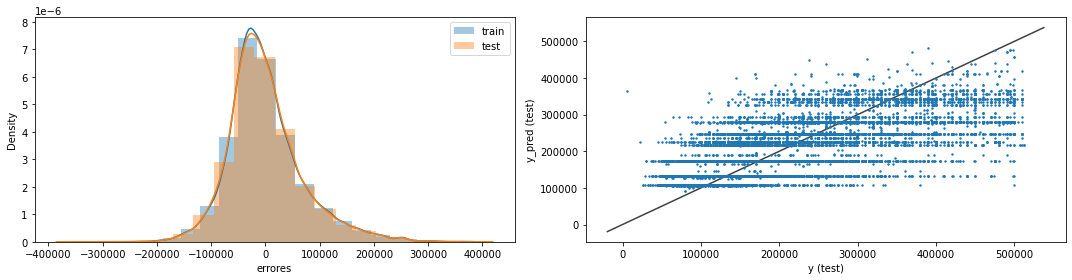

In [144]:
random_forest3 = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,               #Con -1 se utilizan todos los cores disponibles
            random_state = 42
         )
random_forest3.fit(X_train, y_train)
evaluar_modelo(random_forest3, scaler_dependientes,X_train, X_test, y_train, y_test)

<ipython-input-145-ef9132a1ae6d>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest4.fit(X_train, y_train)
C:\Users\vanes\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
<ipython-input-145-ef9132a1ae6d>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest4.fit(X_train, y_train)
C:\Users\vanes\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
<ipython-input-145-ef9132a1ae6

Valor óptimo de n_estimators: 41


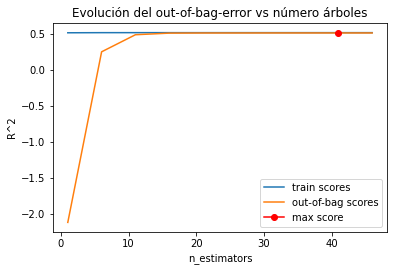

In [145]:
# Validación con Out-of-Bag error
train_scores = []
oob_scores   = []

# Número de estimadores a considerar
estimator_range = range(1, 50, 5)

# Iteramos para distintos valores de n_estimators
for n_estimators in estimator_range:
    random_forest4 = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 42
             )
    random_forest4.fit(X_train, y_train)
    train_scores.append(random_forest4.score(X_train, y_train))
    oob_scores.append(random_forest4.oob_score_)
    
# Graficamos el comportamiento de los errores train y obb_score respecto al número de estimadores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
#Imprimimos el valor óptimo 
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

Se observa nuevamente que aproximadamente a partir de los 10 estimadores el error obb_score del modelo se estabiliza y se vuelve constante, llegando así a su valor más elevado (n_estimators: 41)

<ipython-input-146-26bd576e6aa4>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest5.fit(X_train, y_train)
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Raíz del error cuadrático medio en Train: 68739.02020698761
Raíz del error cuadrático medio en Test: 68422.15276956891
El valor del r2 score : 0.5136934775665942


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


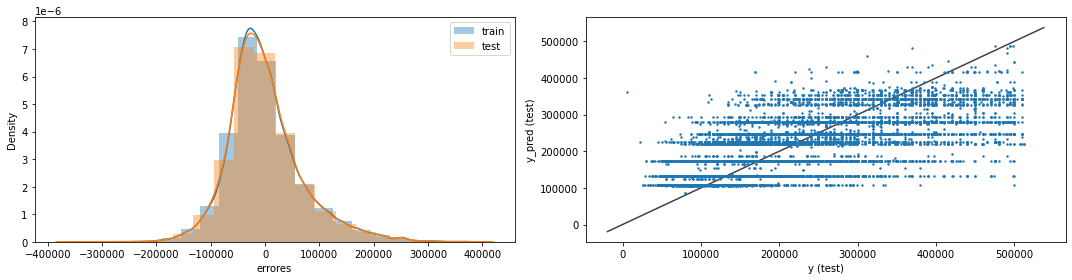

In [146]:
random_forest5 = RandomForestRegressor(
            n_estimators = 41,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,               #Con -1 se utilizan todos los cores disponibles
            random_state = 42
         )
random_forest5.fit(X_train, y_train)
evaluar_modelo(random_forest5, scaler_dependientes,X_train, X_test, y_train, y_test)

C:\Users\vanes\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Importancias')

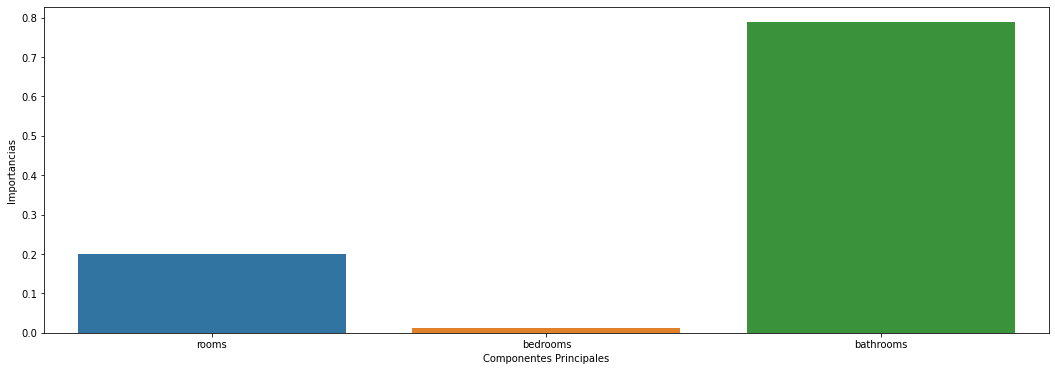

In [147]:
sns.barplot(X.columns, random_forest5.feature_importances_)
plt.xlabel("Componentes Principales")
plt.ylabel("Importancias")

En este caso, el modelo se está entrenando con las variables originales y se obtiene que el atributo que representa la mayor importancia para el modelo es 'bathrooms'. Esto se esperaba ya que es la variable que presenta mayor correlación con la variable a predecir 'price'. 

In [148]:
metricas2= [[40082.58, 46003.66, 0.78],
         [68739.02, 68422.15, 0.51]]


columnas2 = ['RMSE_Train', 'RMSE_Test', 'R2_score',] # definimos los nombres de las columnas
filas2 = ['Random_Forest_PCA', 'Random_Forest_var_corr'] # definimos los nombres de las filas

comparacion2 = pd.DataFrame(metricas2, columns=columnas2, index=filas2)
comparacion2.head()

,RMSE_Train,RMSE_Test,R2_score
Random_Forest_PCA,40082.58,46003.66,0.78
Random_Forest_var_corr,68739.02,68422.15,0.51


Random Forest con componentes principales representa hasta ahora el mejor score y la distribución del error global para el conjunto de train y test con mayor similitud, indicando que no hay existencia de sobreajuste significativa. Además el histograma de errores es bastante simétrico.

## Regresión con Regularización y Atributos Polinómicos

Como hemos visto en la parte A del proyecto, el modelo de regresión lineal es el que peor performance ha arrojado. Esto pudiese estar ligado a la falta de linealidad en nuestro problema. Pensando en esto, consideremos ahora entrenar un modelo de regresión agregando atributos polinómicos usando la función `PolynomialFeatures` de `Scikit-Learn`. 

Además, entrenaremos los modelos aplicandos dos tipos de regularización; la de Ridge y la de Lasso. También, se realizará optimización del parámetro `alpha` que es el que penaliza nuestra función de costo.

### Modelo 12: Regresión Avanzada con PCA

In [154]:
X=X_nuevo
y=df_escalados[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [155]:
poly = PolynomialFeatures(2, include_bias=False)
X_train_new1 = poly.fit_transform(X_train)
X_test_new1 = poly.fit_transform(X_test)
print(X_train_new1.shape, X_test_new1.shape)

(51905, 860) (22246, 860)


### Regularización de Ridge:

In [156]:
reg_ridge = Ridge()

#Random Search
param_dist = {'alpha':np.logspace(-10, 2, 100),   #Esta funcionalidad de numpy nos genera 100 muestras desde 1e-10 a 1e+2, con espaciado logaritmico.
             }       
random_search = RandomizedSearchCV(reg_ridge, param_dist,n_iter=10, random_state=42, cv=5)
random_search.fit(X_train_new1, y_train)
print("Mejores parametros: "+str(random_search.best_params_))
print("Mejor Score: "+str(random_search.best_score_)+'\n')

Mejores parametros: {'alpha': 0.030538555088334123}
Mejor Score: 0.6499303220629813



Raíz del error cuadrático medio en Train: 58194.578337717794
Raíz del error cuadrático medio en Test: 57439.64850818026
El valor del r2 score : 0.6572794286483146


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


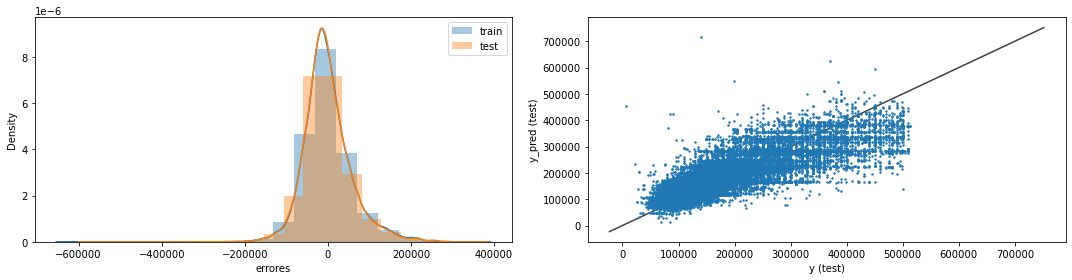

In [157]:
reg_ridge1 = Ridge(alpha=0.030538555088334123)
reg_ridge1.fit(X_train_new1,y_train)
evaluar_modelo(reg_ridge1, scaler_dependientes,X_train_new1, X_test_new1, y_train, y_test)

### Regularización de Lasso:

In [158]:
reg_lasso = Lasso()

#Random Search
param_dist = {'alpha':np.logspace(-10, 2, 100),   
             }       
random_search = RandomizedSearchCV(reg_lasso, param_dist,n_iter=10, random_state=42, cv=5)
random_search.fit(X_train_new1, y_train)
print("Mejores parametros: "+str(random_search.best_params_))
print("Mejor Score: "+str(random_search.best_score_)+'\n')

C:\Users\vanes\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5207150540488783, tolerance: 0.15934377088584845
  model = cd_fast.enet_coordinate_descent(
C:\Users\vanes\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3758971543732059, tolerance: 0.1592317160748076
  model = cd_fast.enet_coordinate_descent(
C:\Users\vanes\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4900194191280889, tolerance: 0.15934377088584845
  model = cd_fast.enet_coordinate_descent(
C:\Users\vanes\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Convergen

Mejores parametros: {'alpha': 5.336699231206313e-06}
Mejor Score: 0.6366512465742761



C:\Users\vanes\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.57803858344334, tolerance: 0.19865439805666035
  model = cd_fast.enet_coordinate_descent(


C:\Users\vanes\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.57803858344334, tolerance: 0.19865439805666035
  model = cd_fast.enet_coordinate_descent(
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Raíz del error cuadrático medio en Train: 59466.234349306054
Raíz del error cuadrático medio en Test: 58648.54647439322
El valor del r2 score : 0.642701549977376


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


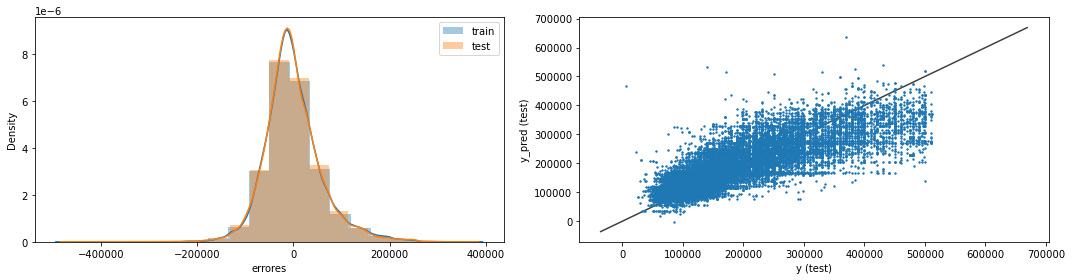

In [159]:
reg_lasso1 = Lasso(alpha = 5.336699231206313e-06)
reg_lasso1.fit(X_train_new1,y_train)
evaluar_modelo(reg_lasso1, scaler_dependientes,X_train_new1, X_test_new1, y_train, y_test)

### Modelo 13: Regresión Avanzada con variables más corr

In [161]:
X=df_escalados[['rooms','bedrooms','bathrooms']]
y=df_escalados[['price']]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)

In [162]:
poly = PolynomialFeatures(3, include_bias=False)
X_train_new2 = poly.fit_transform(X_train)
X_test_new2 = poly.fit_transform(X_test)
print(X_train_new2.shape, X_test_new2.shape)

(51905, 19) (22246, 19)


### Regularización de Ridge:

In [163]:
reg_ridge2 = Ridge()

#Random Search
param_dist = {'alpha':np.logspace(-10, 2, 200),   
             }       
random_search = RandomizedSearchCV(reg_ridge2, param_dist,n_iter=10, random_state=42, cv=5)
random_search.fit(X_train_new2, y_train)
print("Mejores parametros: "+str(random_search.best_params_))
print("Mejor Score: "+str(random_search.best_score_)+'\n')

Mejores parametros: {'alpha': 0.005231099308056258}
Mejor Score: 0.5051860821480656



Raíz del error cuadrático medio en Train: 69594.88183656204
Raíz del error cuadrático medio en Test: 68981.78789580913
El valor del r2 score : 0.5057057953255635


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


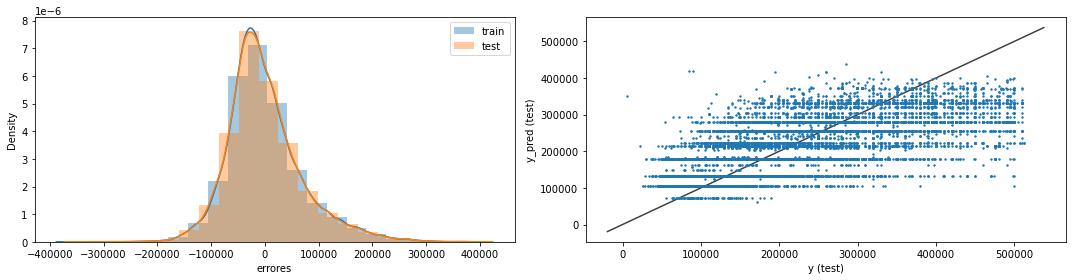

In [166]:
reg_ridge3 = Ridge(alpha= 0.005231099308056258)
reg_ridge3.fit(X_train_new2,y_train)
evaluar_modelo(reg_ridge3, scaler_dependientes,X_train_new2, X_test_new2, y_train, y_test)

### Regularización de Lasso:

In [167]:
reg_lasso2 = Lasso()

#Random Search
param_dist = {'alpha':np.logspace(-10, 2, 100),   
             }       
random_search = RandomizedSearchCV(reg_lasso2, param_dist,n_iter=10, random_state=42, cv=5)
random_search.fit(X_train_new2, y_train)
print("Mejores parametros: "+str(random_search.best_params_))
print("Mejor Score: "+str(random_search.best_score_)+'\n')

C:\Users\vanes\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22956063123513104, tolerance: 0.1592317160748076
  model = cd_fast.enet_coordinate_descent(
C:\Users\vanes\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335.90833466478284, tolerance: 0.15853280808914896
  model = cd_fast.enet_coordinate_descent(
C:\Users\vanes\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 281.1140655598066, tolerance: 0.1592317160748076
  model = cd_fast.enet_coordinate_descent(
C:\Users\vanes\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Convergenc

Mejores parametros: {'alpha': 4.641588833612782e-08}
Mejor Score: 0.5035010473008859



C:\Users\vanes\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 396.9264134024337, tolerance: 0.19865439805666035
  model = cd_fast.enet_coordinate_descent(


C:\Users\vanes\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 396.9264134024337, tolerance: 0.19865439805666035
  model = cd_fast.enet_coordinate_descent(
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Raíz del error cuadrático medio en Train: 69591.3665982962
Raíz del error cuadrático medio en Test: 68975.65096660475
El valor del r2 score : 0.5057937406716659


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


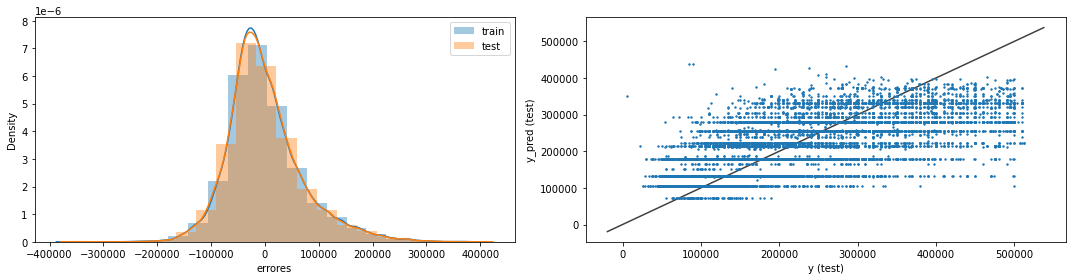

In [168]:
reg_lasso3 = Lasso(alpha = 4.641588833612782e-08)
reg_lasso3.fit(X_train_new2,y_train)
evaluar_modelo(reg_lasso3, scaler_dependientes,X_train_new2, X_test_new2, y_train, y_test)

In [179]:
metricas3= [[58194.57, 57439.64, 0.66,69594.88, 68981.78, 0.51],
            [ 59466.23, 58648.54, 0.64, 69591.36, 68975.65, 0.51]]

columnas3 = ['RMSE_Train_PCA', 'RMSE_Test_PCA', 'R2_score_PCA','RMSE_Train_var_corr','RMSE_Test_var_corr','R2_score_var_corr'] # definimos los nombres de las columnas
filas3 = ['Regularización_Ridge', 'Regularización_Lasso'] # definimos los nombres de las filas

comparacion3 = pd.DataFrame(metricas3, columns=columnas3, index=filas3)
comparacion3.head()

,RMSE_Train_PCA,RMSE_Test_PCA,R2_score_PCA,RMSE_Train_var_corr,RMSE_Test_var_corr,R2_score_var_corr
Regularización_Ridge,58194.57,57439.64,0.66,69594.88,68981.78,0.51
Regularización_Lasso,59466.23,58648.54,0.64,69591.36,68975.65,0.51


Podemos observar que existen mejoras en el modelo de Regresión, considerando atributos polinómicos y regularización de Ridge y de Lasso. Sin embargo, sigue teniendo un performance bastante bajo y con errores muy elevados.

- Para los modelos de regresión avanzada considerados, el mejor performance lo arrojan los entrenados con las componentes principales.
- Es importante destacar que la regularización de Lasso arroja una distribución de densidad de error muy similar para los conjuntos de train y test, además de histogramas simétricos, por lo que si bien no es modelo con mejor r2 score, es el que no presenta sobreajuste.
- La inclusión de atributos polinómicos aporta gran mejoría en los modelos de regresión con regularización respecto a un modelo de regresión lineal benchmark como el considerado en la parte A del proyecto. 

In [180]:
#Tabla final
metricas4= [[65750.65, 64776.66, 0.56,72248.10, 71127.17,0.47],
         [55369.93,55594.84,0.68, 68869.13, 68466.13, 0.51],
         [39261.32,42334.09,0.81, 71935.27, 71387.44,  0.47],
          [41058.51, 49137.44, 0.75,68734.79, 68479.18, 0.51],
         [18377.27,39262.54,0.84,69899.82, 69611.44, 0.50],
          [40082.58, 46003.66, 0.78, 68739.02, 68422.15, 0.51],
          [58194.57, 57439.64, 0.66,69594.88, 68981.78, 0.51],
            [ 59466.23, 58648.54, 0.64, 69591.36, 68975.65, 0.51]]

columnas4 = ['RMSE_Train_PCA', 'RMSE_Test_PCA', 'R2_score_PCA', 'RMSE_Train_var_corr', 'RMSE_Test_var_corr', 
            'R2_score_var_corr'] # definimos los nombres de las columnas
filas4 = ['Regresión lineal', 'Árbol de Decisión', 'KNN','Árbol de Decisión CV', 'KNN CV', 'Random Forest', 'Regresión Reg Ridge', 'Regresión Reg Lasso'] # definimos los nombres de las filas

comparacion4 = pd.DataFrame(metricas4, columns=columnas4, index=filas4)

# Conclusiones

A lo largo de todo el proyecto se ha trabajado de forma iterativa para encontrar el modelo que mejor prediga el precio de una propiedad en base a sus características. Comparando el desempeño de los modelos tomando en cuenta las componentes principales que aportan mayor variabilidad al problema y también, considerando usar las variables predictoras que presentan mayor correlación con la variable objtivo.

En la siguiente tabla recolectamos todos los resultados:

In [181]:
comparacion4

,RMSE_Train_PCA,RMSE_Test_PCA,R2_score_PCA,RMSE_Train_var_corr,RMSE_Test_var_corr,R2_score_var_corr
Regresión lineal,65750.65,64776.66,0.56,72248.10,71127.17,0.47
Árbol de Decisión,55369.93,55594.84,0.68,68869.13,68466.13,0.51
KNN,39261.32,42334.09,0.81,71935.27,71387.44,0.47
Árbol de Decisión CV,41058.51,49137.44,0.75,68734.79,68479.18,0.51
KNN CV,18377.27,39262.54,0.84,69899.82,69611.44,0.50
Random Forest,40082.58,46003.66,0.78,68739.02,68422.15,0.51
Regresión Reg Ridge,58194.57,57439.64,0.66,69594.88,68981.78,0.51
Regresión Reg Lasso,59466.23,58648.54,0.64,69591.36,68975.65,0.51


* El modelo de vecinos más cercanos arroja un R2 alto, pero presenta overfitting ya que los errores de train y test difieren bastante, lo que indica que el modelo está aprendiendo demasiado de los datos pero esta prediciendo de forma fallida. Es importante resaltar que KNN presenta menor overfitting cuando se considera estimar los pesos de forma uniforme que con el inverso de la distancia.

* El mejor modelo entrenado con nuestros datos es el Random Forest, arroja los errores más bajos, con distribuciones de errores de train y test menor sobreajuste y un R2 score de 0.78. Lo cual indica que estamos aproximando nuestros datos de buena manera. 

* Los modelos regresión mejoran con la transformación de los datos, la inclusión de atributos polinómicos y regularización con una variación considerable del parámetro alpha. El modelo de regularización de Lasso presenta una muy buena distribución de errores para los conjuntos de train y test, además el gráfico de valores predichos y valores reales presentan menor dispersión y se ajustan más a la recta, lo cual indica que es un buen regresor.

* Se resalta la importancia de la reducción de la dimensionalidad. Los modelos de árboles, vecinos y random forest; son los que presentan mejor performance con estas variables.

Considero que se podría mejorar el desempeño de los modelos prestando atención a las variables de superficie total y cubierta. Evaluar con los expertos el tema de si éstas variables tienen un distribución común o están sesgadas de alguna forma y por esto presentan valores atípicos que podamos luego remover con mayor certeza.

# Clustering Prueba (Extra)

Después de algunas iteraciones encontré que agregando las variables binarias generadas a partir de la variable property_type, la el diagrama de dispersión de las dos primeras componentes principales muestran cierto patrón de agrupamiento, tal como se muestra a continuación:

In [172]:
X=df_escalados[['Casa','Departamento','PH','rooms','bedrooms','bathrooms', 'surface_total', 'surface_covered']]
y=df_escalados[['price']]

In [173]:
pca = PCA(n_components=2)
X_nuevo = pca.fit_transform(X) 

In [174]:
pca.components_

array([[ 6.06888882e-02, -7.34391645e-01,  6.73702756e-01,
         3.70042273e-02,  4.01727081e-02,  1.12603338e-02,
         5.41997529e-04,  3.44701540e-04],
       [ 8.07753319e-01, -3.46948730e-01, -4.60804588e-01,
         7.71567339e-02,  7.99391958e-02,  4.97582022e-02,
         7.62148119e-04,  6.24624079e-04]])

In [175]:
pca.explained_variance_ratio_

array([0.84423724, 0.12117149])

Text(0, 0.5, 'PC2')

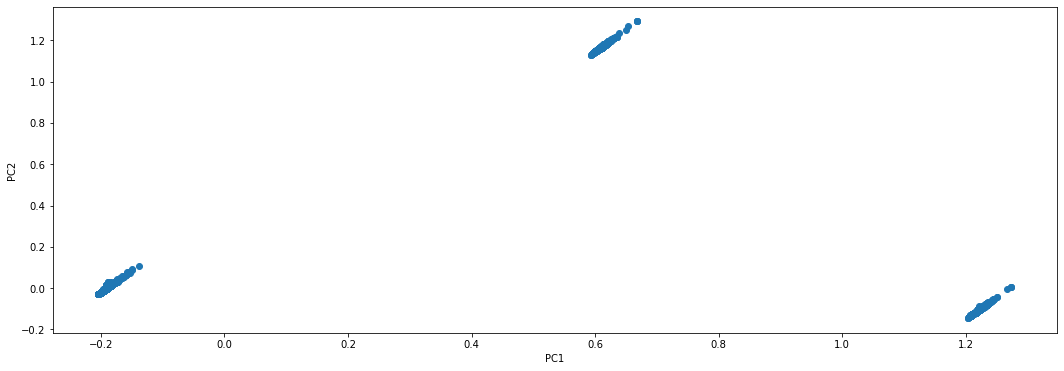

In [176]:
plt.scatter(X_nuevo[:,0], X_nuevo[:,1] )
plt.xlabel('PC1')
plt.ylabel('PC2')

Se observan 3 grupos bien definidos. Apliquemos ahora la técnica de K-means

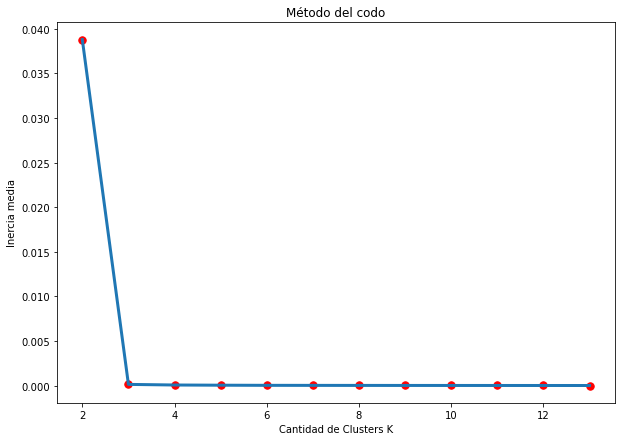

In [177]:
# Preparamos una lista donde vamos a ir agregando las distancias medias
Sum_of_squared_distances = []
# Fiteammos un modelo para cada numero de cluster que queremos testear
K = np.arange(2,14)
for k in K:
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(X_nuevo)
    # Calculamos la distancia media y agregamos a la lista
    distancia_total = km.inertia_
    distancia_media = np.divide(distancia_total,X_nuevo.shape[0]) #OJO
    Sum_of_squared_distances.append(distancia_media)
    
plt.figure(figsize = (10,7))
plt.plot(K, Sum_of_squared_distances, lw=3)
plt.scatter(K, Sum_of_squared_distances,s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Inercia media')
plt.title('Método del codo')

plt.show()

Se evidencia de forma clara que el número de clusters idóneo es k=3, ahora entrenemos el modelo:

C:\Users\vanes\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vanes\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


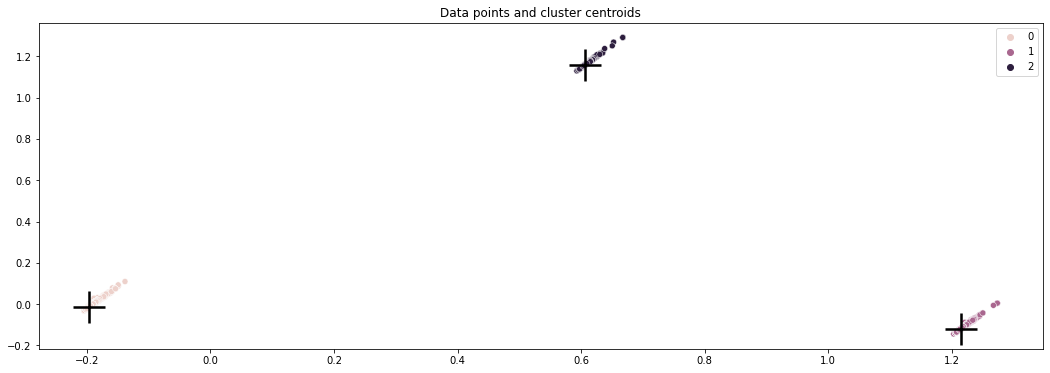

In [178]:
# Defino y entreno el modelo
km = KMeans(n_clusters=3)
km = km.fit(X_nuevo)
# Obtengo la posición de los centros y las etiquetas
etiquetas_ = km.labels_
centros_ = km.cluster_centers_
# Plotting the cluster centers and the data points on a 2D plane
sns.scatterplot(X_nuevo[:,0], X_nuevo[:,1], hue = etiquetas_)
sns.scatterplot(centros_[:, 0], centros_[:, 1],color='black', marker="+", s=1000)
plt.title('Data points and cluster centroids')
plt.show()

Si bien el objetivo del proyecto es predecir el precio de una propiedad a partir de sus características, acá podemos evidenciar un modelo que nos permita clasificar propiedades de acuerdo a su tipo. En este caso, los clusters encontrados probablemente están relacionados con el hecho de si una propiedad es de tipo Casa, Departamento o PH.